# Mock MaNGA datacubes

### This notebook shows how to go from the synthetic iMaNGA datacubes, publicly available, to a mock MaNGA observation

#### It can be applied to any other syntethic datacube
#### It can be modified to obtain other mock observations


#### If used for scientific publications, please, cite Nanni+2022 for the datacubes, Nanni+2023a and Nanni+2023b for the iMaNGA VAC

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import mplt_style
plt.style.use(mplt_style.style1)

### Selecting a galaxy

In [3]:
snap = 96 # running as .py you can pass it as an argument when running the script int(float(sys.argv[1]))
gal = 3  # int(float(sys.argv[2]))


Using the Api to download the iMaNGA files.

Here we download the datacube for the galaxy ID=3 in snapshot=96, used in the first paper of the series as an example (https://academic.oup.com/mnras/article/515/1/320/6603844)

It is also possible to download the files directly from https://www.tng-project.org/data/docs/specifications/#sec5_4 and for this example galaxy: http://www.tng-project.org/api/TNG50-1/snapshots/96/subhalos/3/imanga.fits


In [4]:
import iMANGA_functions as iMANGA

In [5]:
url = "http://www.tng-project.org/api/TNG50-1/snapshots/"+str(snap)+"/subhalos/"+str(gal)+"/imanga.fits"

r = iMANGA.get(url)

In [6]:
from astropy.io import fits

In [7]:
datacube = fits.getdata(r)

Now that the datacube is ready to be used, we can also download the information for the galaxy (such as morphology information) available thanks to the iMaNGA VAC (see Nanni+2022, Nanni+2023a and Nanni+2023b to know more about the data analysis followed)


The iMaNGA VAC needs to be downloaded from https://www.tng-project.org/data/docs/specifications/#sec5_4

In [8]:
VAC_path = "/mnt/lustre2/manga/iMaNGA_VAC.fit"

In [9]:
VAC =  fits.open(VAC_path)

In [10]:
galaxy_id_VAC = np.where(VAC[1].data['TNG_snap_id']==str(snap)+"-"+str(gal))[0][0] # index of the galaxy in the iMaNGA VAC

### We now input the FoV grid

In [11]:
grid_ =  VAC[3].data[3,galaxy_id_VAC,:,:] # FoV grid

### Now we apply this mask to the datacube

In [12]:
grid, FoV_datacube = iMANGA.apply_FOV(grid_, datacube)

In [13]:
from astropy.visualization import simple_norm


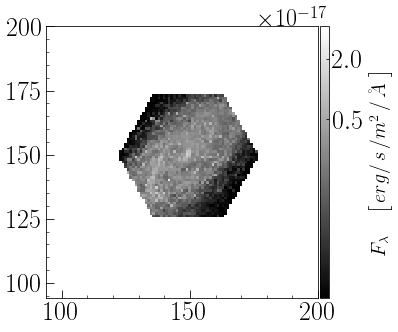

In [14]:
fig = plt.figure(1, figsize=(6, 5))
fig.patch.set_facecolor('white')
ax=plt.subplot(111)
ax.minorticks_on()
ax.tick_params(length=8, which='major', direction="in", labelsize=26)
ax.tick_params(length=3, which='minor', direction="in", labelsize=26)


im = ax.imshow(FoV_datacube[300,:,:].T,cmap='gray'\
              , zorder=2,interpolation='nearest', origin='lower',\
               norm=simple_norm(FoV_datacube[3000,:,:].T, stretch='log', log_a=500))

cbar = plt.colorbar(im,ax=ax, pad = .0050, aspect=30)
cbar.ax.tick_params(labelsize=26, axis='y', direction='in', )

cbar.set_ticks([0.5*10**-17, 2*10**-17])


cbar.set_label(r'$ F_\lambda\quad\left[\,erg/\,s \,/m^2\,/\,\AA \,\,\right]$',fontsize=20);
cbar.ax.yaxis.get_offset_text().set_fontsize(24)


ax.set_xlim(94,200)
ax.set_ylim(94,200);


### Adding the noise 

As presented in Nanni+2022, we define the SNR as a function of the wavelength from MaNGA observation. 

The data are here available here. This is computed as the average of SNR functions for 100 randomly selected MaNGA galaxies, considering the spectra at around 1.5 Reff. Change the path accordingly. 

Including here another SNR function, other mocks can be created


In [15]:
snr_file = np.genfromtxt("./iMaNGA/snr_average.dat")

snr = snr_file[:,1]

In [16]:
redshift = VAC[1].data[2][galaxy_id_VAC]

We here use the MaStar wavelegths, the file is available here: https://www.icg.port.ac.uk/mastar/

In [17]:
ver = str("v1.1")
lib = str("th")

hdul = fits.open('./iMaNGA/MaStar_SSP_'+ver+'.fits')
wave_rest=hdul[2].data[0,:] #lambda array
wave= wave_rest*(1+redshift)
hdul.close()

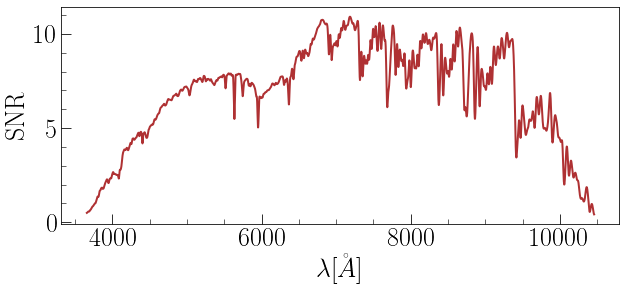

In [18]:
fig, ax = plt.subplots(figsize=(10,4))
ax = fig.gca()
ax.minorticks_on()
ax.tick_params(length=10, which='major', direction="in", labelsize=26)
ax.tick_params(length=5, which='minor', direction="in", labelsize=26)

plt.plot(wave, snr, linewidth=2, color = "#AF3133");

plt.ylabel('SNR', fontsize=26); 
plt.xlabel(r'$\lambda [\r{A}]$', fontsize=26);

#### Now, we can include the noise spaxel per spaxel, as in Eq. 4 in Nanni+2022

In [19]:
grid_zero = grid.copy()
grid_zero[grid==True] = np.nanmin(FoV_datacube[:, (grid==True)],axis=0)>0

bkg_x = np.where((grid == True)&(grid_zero==True))[0][-1]
bkg_y = np.where((grid == True)&(grid_zero==True))[1][-1]

In [20]:
bkg_  = FoV_datacube[:, bkg_x, bkg_y]

In [21]:
pflux = np.zeros((FoV_datacube.shape))
newnoise = np.zeros((FoV_datacube.shape))

newnoise[:,:,:] = abs(np.sqrt(FoV_datacube[:,:,:])* (np.sqrt(bkg_.reshape(-1,1,1))/snr.reshape(-1,1,1)))
pflux[:,:,:] = np.random.normal(FoV_datacube[:,:,:], scale = newnoise[:,:,:])

In [22]:
# to avoid unphysical noise produced by the random process 
pflux[np.less(pflux, 0., where=~np.isnan(pflux))] = np.min(pflux[np.greater(pflux, 0., where=~np.isnan(pflux))])
newnoise[np.less(newnoise, 0., where=~np.isnan(newnoise))] = np.min(newnoise[np.greater(newnoise, 0., where=~np.isnan(newnoise))])

#### Here it follows some examples of the effects of adding the noise to the spectra in different ares

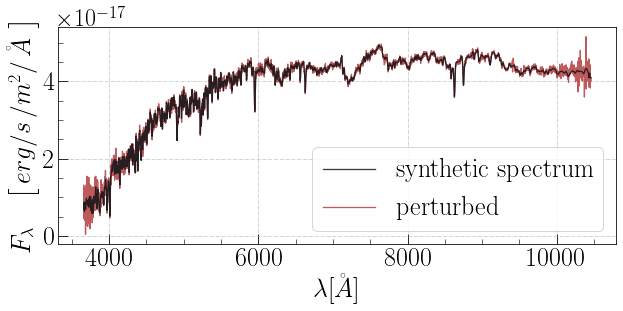

In [23]:
fig, ax = plt.subplots(figsize=(10,4))
ax = fig.gca()
ax.minorticks_on()
ax.tick_params(length=10, which='major', direction="in", labelsize=26)
ax.tick_params(length=5, which='minor', direction="in", labelsize=26)

plt.plot(wave, FoV_datacube[:, 150, 150], '-', alpha=.8, color='#010F13', linewidth=1.3, label='synthetic spectrum', zorder=3)
plt.plot(wave, pflux[:, 150, 150], '-', alpha=0.8, color='#AF3133', linewidth=1.3, label=r'perturbed', zorder=2)



plt.ylabel(r'$ F_\lambda\quad\left[\,erg/s \,/m^2/\,\AA \,\,\right]$', fontsize=26); 
plt.xlabel(r'$\lambda [\r{A}]$', fontsize=26) #micron
plt.legend(fontsize=26)
plt.grid(ls = '-.', lw = 0.55)
ax.yaxis.get_offset_text().set_fontsize(24)


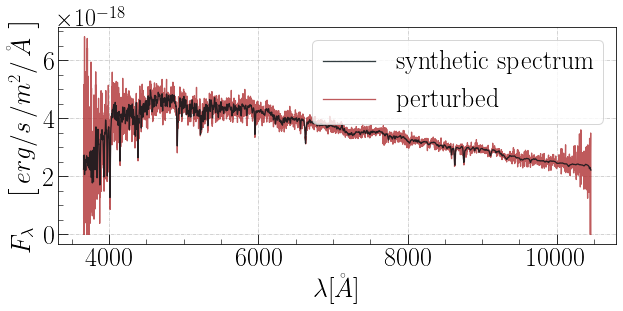

In [24]:
fig, ax = plt.subplots(figsize=(10,4))
ax = fig.gca()
ax.minorticks_on()
ax.tick_params(length=10, which='major', direction="in", labelsize=26)
ax.tick_params(length=5, which='minor', direction="in", labelsize=26)

plt.plot(wave, FoV_datacube[:, 140, 143], '-', alpha=.8, color='#010F13', linewidth=1.3, label='synthetic spectrum', zorder=3)
plt.plot(wave, pflux[:, 140, 143], '-', alpha=0.8, color='#AF3133', linewidth=1.3, label=r'perturbed', zorder=2)



plt.ylabel(r'$ F_\lambda\quad\left[\,erg/s \,/m^2/\,\AA \,\,\right]$', fontsize=26); 
plt.xlabel(r'$\lambda [\r{A}]$', fontsize=26) #micron
plt.legend(fontsize=26)
plt.grid(ls = '-.', lw = 0.55)
ax.yaxis.get_offset_text().set_fontsize(24)

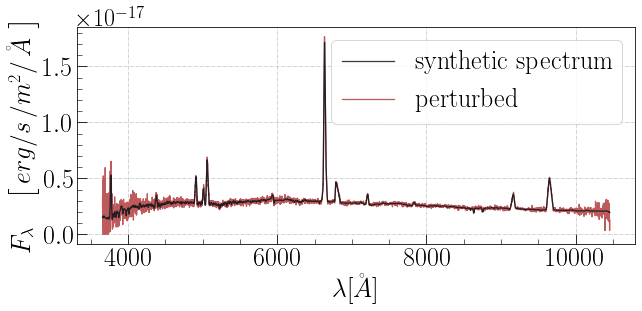

In [25]:
fig, ax = plt.subplots(figsize=(10,4))
ax = fig.gca()
ax.minorticks_on()
ax.tick_params(length=10, which='major', direction="in", labelsize=26)
ax.tick_params(length=5, which='minor', direction="in", labelsize=26)

plt.plot(wave, FoV_datacube[:, 140, 140], '-', alpha=.8, color='#010F13', linewidth=1.3, label='synthetic spectrum', zorder=3)
plt.plot(wave, pflux[:, 140, 140], '-', alpha=0.8, color='#AF3133', linewidth=1.3, label=r'perturbed', zorder=2)



plt.ylabel(r'$ F_\lambda\quad\left[\,erg/s \,/m^2/\,\AA \,\,\right]$', fontsize=26); 
plt.xlabel(r'$\lambda [\r{A}]$', fontsize=26) #micron
plt.legend(fontsize=26)
plt.grid(ls = '-.', lw = 0.55)
ax.yaxis.get_offset_text().set_fontsize(24)

### We can now add the effect of the point spread function

#### the point spread function, being added after the noise, make sure to reproduce the covariance among adjacent spacels in the datacube


#### we make use of the SDSS filters to convolve with the effective PSF in the differnt wavelegth band

##### this data are made available, change the path accordingly

In [26]:
filer_g = np.genfromtxt('./iMaNGA/sdss_filters/SLOAN_SDSS.g.dat')
wave_g = filer_g[:,0]
response_g = filer_g[:,1]

filer_r = np.genfromtxt('./iMaNGA/sdss_filters/SLOAN_SDSS.r.dat')
wave_r = filer_r[:,0]
response_r = filer_r[:,1]

filer_i = np.genfromtxt('./iMaNGA/sdss_filters/SLOAN_SDSS.i.dat')
wave_i = filer_i[:,0]
response_i = filer_i[:,1]

filer_z = np.genfromtxt('./iMaNGA/sdss_filters/SLOAN_SDSS.z.dat')
wave_z = filer_z[:,0]
response_z = filer_z[:,1]


### We construct an average effective PSF in MaNGA observation (see Nanni+2022)
#### it is available to be used

In [27]:
hdu_psf, headerPSF = fits.getdata("./iMaNGA/sdss_filters/ePSF.fits.gz", header=True)

psfg = hdu_psf[:,:, 0]
psfr = hdu_psf[:,:, 1]
psfi = hdu_psf[:,:, 2]
psfz = hdu_psf[:,:, 3]

##### Now we convolve the datacubes with the effective PSF

##### WARNING: it might takes a few minutes

In [28]:
from astropy.convolution import convolve

In [29]:
# We can resize the matrix for faster computation and lower computational cost when saving the files

In [30]:
pflux_300 = pflux[:,~np.isnan(pflux[300,:,:]).all((1))]
pflux_300 = pflux_300[:,:,~np.isnan(pflux[300,:,:]).all((1))]

In [31]:
grid = np.where(grid==0, np.nan,grid)
grid_300 = grid[:,~np.isnan(grid).all(1)]
grid_300 = grid_300[~np.isnan(grid).all(1)]

In [32]:
im_convoluta = np.zeros((np.shape(pflux_300)))
for k in range(len(wave)):
    if wave[k]<=wave_r.min():
        im_convoluta[k, :,:] = np.where(grid_300==True, convolve(pflux_300[k, :,:], psfg), float("Nan"))
    if wave_r.min()<wave[k]<=wave_g.max():
        im_convoluta[k, :,:] = np.where(grid_300==True, convolve(pflux_300[k, :,:], np.mean((psfr, psfg), axis=0)), float("Nan"))
    if wave_g.max()<wave[k]<=wave_i.min():
        im_convoluta[k, :,:] = np.where(grid_300==True, convolve(pflux_300[k, :,:], psfr), float("Nan"))
    if wave_i.min()<wave[k]<=wave_r.max():
        im_convoluta[k, :,:] = np.where(grid_300==True, convolve(pflux_300[k, :,:], np.mean((psfr, psfi), axis=0)), float("Nan"))
    if wave_r.max()<wave[k]<=wave_z.min():
        im_convoluta[k, :,:] = np.where(grid_300==True, convolve(pflux_300[k, :,:],psfi), float("Nan"))
    if wave_z.min()<wave[k]<=wave_i.max():
        im_convoluta[k, :,:] = np.where(grid_300==True, convolve(pflux_300[k, :,:],np.mean((psfi, psfz), axis=0)), float("Nan"))
    if wave_i.max()<wave[k]<=wave_z.max():
        im_convoluta[k, :,:] = np.where(grid_300==True, convolve(pflux_300[k, :,:],psfz), float("Nan"))    
    if wave[k]>wave_z.max():
        im_convoluta[k, :,:] = np.where(grid_300==True, convolve(pflux_300[k, :,:],psfz), float("Nan"))    

